In [1]:
## modify us
## inputs
select_id_file = "BST_output/E14.5_embryo_dox_E10.5_CA/01.fastq2BcUmi/out.select_id"
parsed_barcodes_file = "BST_output/E14.5_embryo_dox_E10.5_CA/01.fastq2BcUmi/out.bc_umi_read.tsv.id"
dar_reads = "cutadapt/E14.5_embryo_dox_E10.5_CA_R2.trimmed.fastq.gz"
sample = "E14.5_embryo_dox_E10.5"
## outputs
features_file = "BST_output/E14.5_embryo_dox_E10.5_CA/02.Umi2Gene/features.tsv"
umi2gene_file = "BST_output/E14.5_embryo_dox_E10.5_CA/02.Umi2Gene/out.umi_gene.tsv"
output_dir = "BST_output/E14.5_embryo_dox_E10.5_CA/02.Umi2Gene/"

In [1]:
# Parameters
select_id_file = "BST_output/Y007_SI_Doud_TA/01.fastq2BcUmi/out.select_id"
parsed_barcodes_file = "BST_output/Y007_SI_Doud_TA/01.fastq2BcUmi/out.bc_umi_read.tsv.id"
features_file = "BST_output/Y007_SI_Doud_TA/02.Umi2Gene/features.tsv"
umi2gene_file = "BST_output/Y007_SI_Doud_TA/02.Umi2Gene/out.umi_gene.tsv"
dar_reads = "cutadapt/Y007_SI_Doud_TA_R2.trimmed.fastq.gz"
sample = "Y007_SI_Doud"
output_dir = "BST_output/Y007_SI_Doud_TA/02.Umi2Gene"

In [ ]:
## Parameters
DARLIN_denoise_reads_cutoff = 10

## Denoise clone sequence
distance_relative_threshold=None
distance_absolute_threshold=1

## Drop the sequence with potential sequencing error
slope_threshold=10

## Reads per allele group for filtering
min_reads_per_allele_group=3
perc_reads_per_allele_group=0.01

## Dominant clone filtering
read_fraction_per_clone_cell_cutoff=0.2

In [2]:
import os
import gzip
import pandas as pd
import numpy as np
import warnings
from Bio import SeqIO
from mosaiclineage import larry

import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

/home/jianing/miniconda3/envs/DARLIN_analysis/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Load and extract DARLIN, spatial bc, and UMI 

In [4]:
# load DARLIN sequence
seq_list = []
with gzip.open(dar_reads, "rt") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        seq_list.append(str(record.seq))

In [5]:
# filter by valid barcodes
select_id = [int(i.rstrip()) for i in open(select_id_file).readlines()]
N_total_reads = len(seq_list)
N_valid_barcodes = len(select_id)
ratio = N_valid_barcodes / N_total_reads * 100
messages = f"Total reads:\t\t{N_total_reads}\nValid barcodes:\t\t{N_valid_barcodes}({ratio:.2f}%)"
print(messages)
seq_list = [seq_list[i] for i in select_id]

Total reads:		37901479
Valid barcodes:		35048665(92.47%)


In [6]:
# load spatial barcodes & umi
bc_list, umi_list, read_id_list = [], [], []
with open(parsed_barcodes_file, 'r') as fi:
    for line in fi:
        items = line.rstrip().split('\t')
        for i in items[2:]:
            read_id_list.append(int(i))
            bc_list.append(items[0])
            umi_list.append(items[1])

In [7]:
# load into dataframe
df_seq = pd.DataFrame(
    {
        "cell_bc": bc_list,
        "umi": umi_list,
        "read_id": read_id_list
    }
)

df_tmp = pd.DataFrame(
    {
        "Seq": seq_list,
        "read_id": select_id
    }
)

## merge DARLIN [read2] and spatial bc+umi [read1]
df_seq = pd.merge(df_seq, df_tmp, on='read_id', how='outer')
assert df_tmp.shape[0] == df_seq.shape[0], "The barcode and darlin sequence are not matched!"
del df_tmp
## rename columns
df_seq["clone_id"] = df_seq["Seq"]
df_seq = df_seq.drop(["read_id", "Seq"], axis=1)

## Count reads by spatial bc + umi + DARLIN sequence

In [8]:
df_seq["unique_id"] = (
    df_seq["cell_bc"] + "_" + df_seq["umi"] + "_" + df_seq["clone_id"]
)
df_tmp = (
    df_seq.groupby("unique_id").agg(
        read=("unique_id", "count")).reset_index()
)
df_seq = df_seq.filter(
    [
        "cell_bc",
        "umi",
        "clone_id",
        "unique_id",
    ]
).merge(df_tmp, on="unique_id").drop(["unique_id"], axis=1).drop_duplicates()

del df_tmp

In [9]:
## remove columns
df_seq.columns = ['cell_bc', 'umi', 'clone_id', 'read']
df_seq['library'] = sample
df_seq["cell_id"] = df_seq["library"] + "_" + df_seq["cell_bc"]
df_seq["umi_id"] = df_seq["cell_bc"] + "_" + df_seq["umi"]
df_seq['raw_seq'] = df_seq['clone_id']

## Slope filtering

Identified 84764 putative cell_id


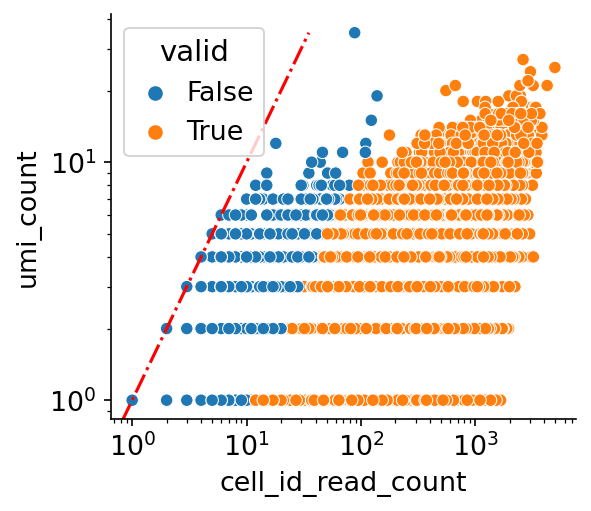

In [62]:
if slope_threshold is not None:
    df_valid_cells = larry.extract_putative_valid_cell_id(df_seq, signal_threshold=slope_threshold, cell_key="cell_id")
else:
    df_valid_cells = df_seq.copy()

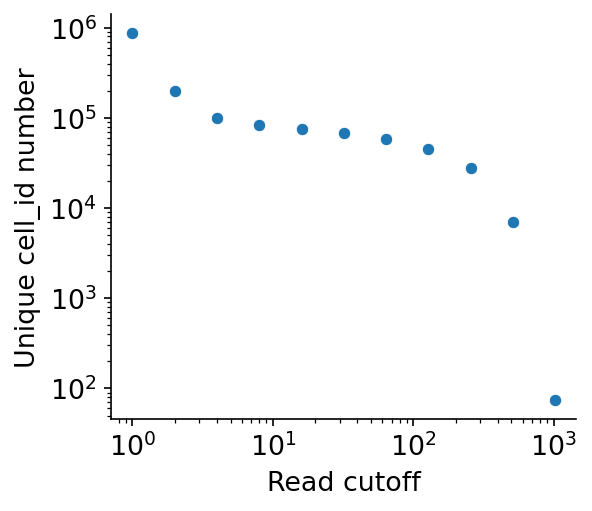

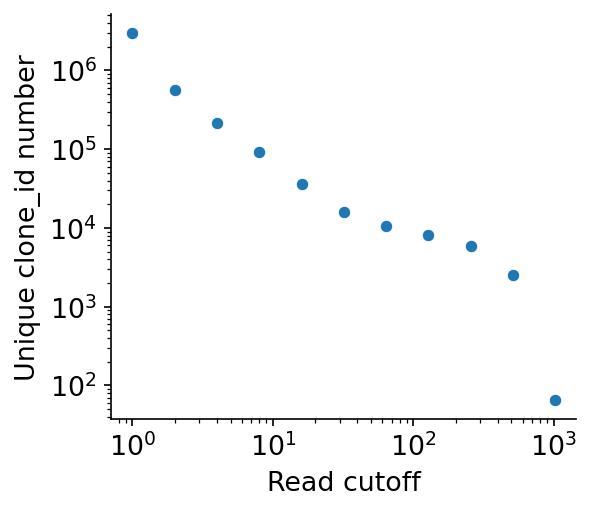

In [11]:
df_unique = larry.QC_unique_cells(df_seq, target_keys=['cell_id','clone_id'])

In [12]:
larry.print_statistics(df_seq)

library number: 1
cell_id number: 879231
clone_id number: 3014442
umi_id number: 1138693
total reads: 35049K


## Denoise DARLIN sequence

Text(0.5, 1.0, 'Raw CARLIN length dist (UMI): 8580645 count')

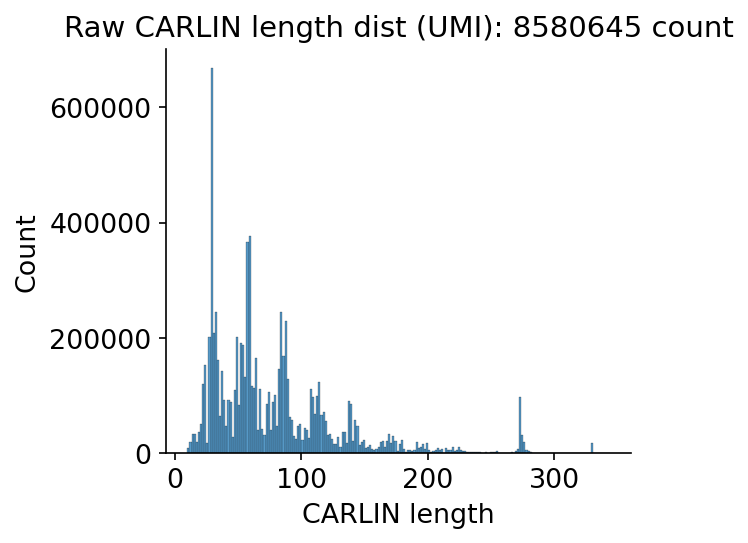

In [15]:
df_filter_reads = df_seq.copy()
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=df_filter_reads['bc_length'] #list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=20)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Raw CARLIN length dist (UMI): {len(unique_bc_length)} count')

In [53]:
df_list_group=[]
df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    if distance_relative_threshold is not None:
        distance_threshold=np.max([1,int(target_length*distance_relative_threshold)])
    else:
        distance_threshold=distance_absolute_threshold
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        denoise_method="Hamming",  # UMI_tools, 'Hamming'
        distance_threshold=distance_threshold, 
        read_cutoff=DARLIN_denoise_reads_cutoff, 
        whiteList=None,
        plot_report=False,
        progress_bar=False)
    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_HQ_group['bc_length']=target_length
    df_list.append(df_HQ)
    df_list_group.append(df_HQ_group)

df_denoise_bc_0=pd.concat(df_list)
df_denoise_bc_group_0=pd.concat(df_list_group)

In [54]:
larry.print_statistics(df_denoise_bc_group_0)

library number: 1
cell_id number: 99411
clone_id number: 28323
total reads: 25590K


## Allele group filtering

In [56]:
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells_per_clone(df):
    coarse_grained_readcutoff=np.max([min_reads_per_allele_group, perc_reads_per_allele_group*df['read'].max()])
    # return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]
    return df[(df['read']>=coarse_grained_readcutoff) ]

if min_reads_per_allele_group is not None:
    df_denoise_bc_group_1 = df_denoise_bc_group_0.groupby('clone_id',group_keys=True).apply(filter_low_read_cells_per_clone).reset_index(drop=True)
else:
    df_denoise_bc_group_1 = df_denoise_bc_group_0.copy()

In [57]:
larry.print_statistics(df_denoise_bc_group_1)

library number: 1
cell_id number: 81100
clone_id number: 28323
total reads: 25444K


In [58]:
# Obtain the dominant barcode in each cell
df_denoise_bc_group_2=larry.calculate_read_fraction_per_clone_cell(df_denoise_bc_group_1,norm_mode='max') # norm_mode: 'max', or 'sum'
df_denoise_bc_group_3=df_denoise_bc_group_2[(df_denoise_bc_group_2['cell_read_fraction']>read_fraction_per_clone_cell_cutoff)]

Text(0, 0.5, 'Fraction of reads in a clone \nfor different cells')

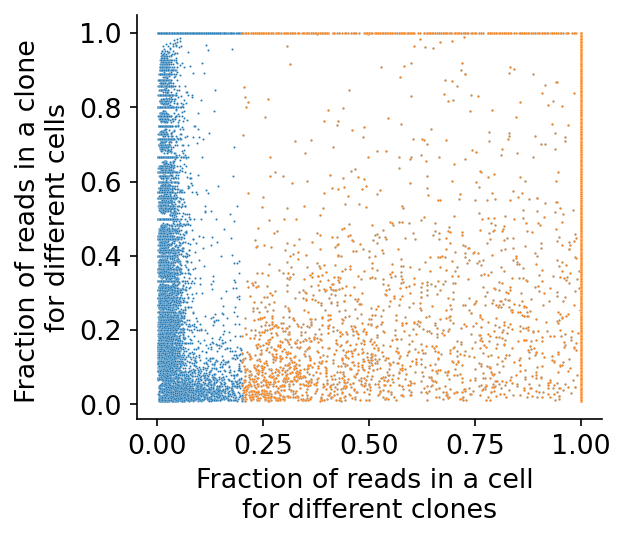

In [59]:
import matplotlib.pyplot as plt

sns.scatterplot(data=df_denoise_bc_group_3,x='cell_read_fraction',y='clone_read_fraction',s=1)
plt.xlabel('Fraction of reads in a cell \nfor different clones')
plt.ylabel('Fraction of reads in a clone \nfor different cells')

In [63]:
# only keep the valid cells (real slope filtering)
df_denoise_bc_group_4 = df_denoise_bc_group_3[df_denoise_bc_group_3['cell_id'].isin(df_valid_cells['cell_id'])]

## QC metrics

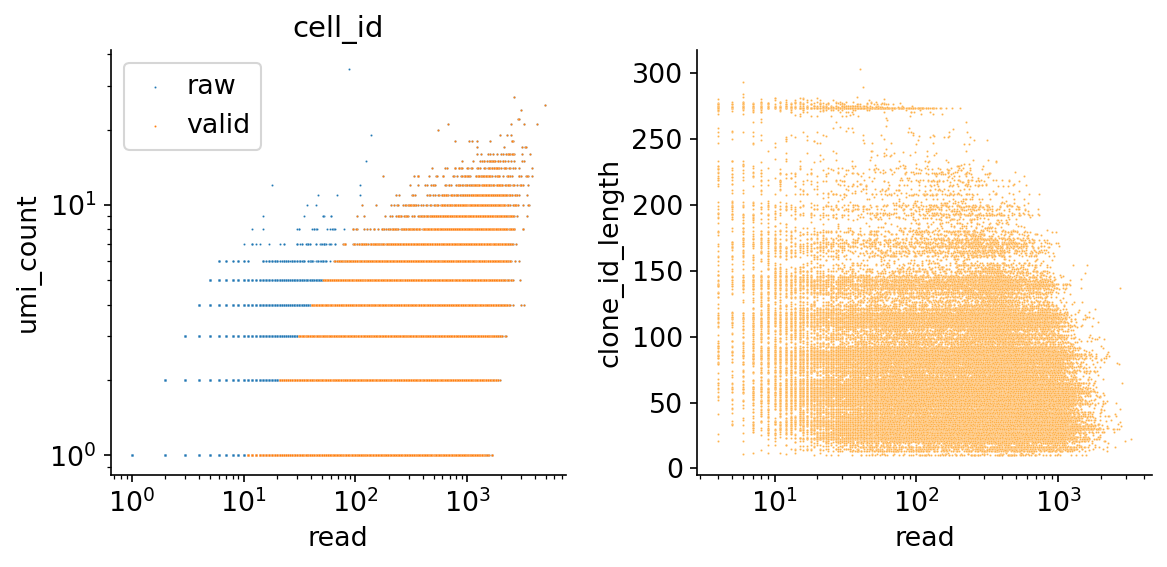

In [64]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_denoise_bc_group_4,marker_size=1)

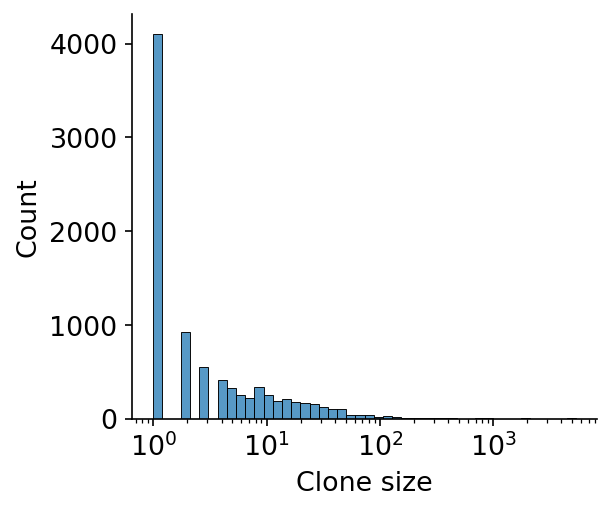

In [65]:
df_stats=larry.QC_clone_size(df_denoise_bc_group_4, read_cutoff=0, plot=True, log_scale=True)

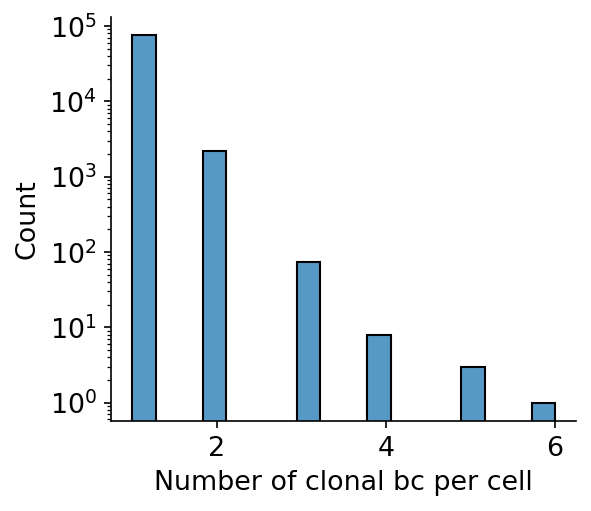

In [66]:
df_stats2 = larry.QC_clonal_bc_per_cell(df_denoise_bc_group_4, read_cutoff=0)
plt.yscale('log')

In [67]:
larry.print_statistics(df_denoise_bc_group_4)

library number: 1
cell_id number: 77655
clone_id number: 8804
total reads: 25039K


In [70]:
df_denoise_bc_0['idx'] = df_denoise_bc_0['cell_bc'] + '_' + df_denoise_bc_0['clone_id']
df_denoise_bc_group_4['idx'] = df_denoise_bc_group_4['cell_bc'] + '_' + df_denoise_bc_group_4['clone_id']

In [71]:
df_final = df_denoise_bc_0[df_denoise_bc_0['idx'].isin(df_denoise_bc_group_4['idx'])].copy()

In [72]:
larry.print_statistics(df_denoise_bc_0)

library number: 1
cell_id number: 99411
clone_id number: 28323
total reads: 25590K


In [73]:
larry.print_statistics(df_final)

library number: 1
cell_id number: 77655
clone_id number: 8804
total reads: 25039K


## Save results for spatial

1. `umi_gene.tsv`: UMI to DARLIN
2. `features.tsv`: DARLIN species (clone id)

In [74]:
df_final.head()

,cell_bc,clone_id,umi,cell_id,library,read,idx
1,V2Abc1_108-V2Abc2_145-V2Bbc3_161,TCGCTATGGA,TTATACACGAGT,Y007_SI_Doud_V2Abc1_108-V2Abc2_145-V2Bbc3_161,Y007_SI_Doud,94,V2Abc1_108-V2Abc2_145-V2Bbc3_161_TCGCTATGGA
6,V2Abc1_112-V2Bbc2_351-V2Bbc3_30,TCGCTATGGA,CGGAGGGTCCGG,Y007_SI_Doud_V2Abc1_112-V2Bbc2_351-V2Bbc3_30,Y007_SI_Doud,379,V2Abc1_112-V2Bbc2_351-V2Bbc3_30_TCGCTATGGA
7,V2Abc1_112-V2Bbc2_351-V2Bbc3_30,TCGCTATGGA,CTAGCGATCGAG,Y007_SI_Doud_V2Abc1_112-V2Bbc2_351-V2Bbc3_30,Y007_SI_Doud,5,V2Abc1_112-V2Bbc2_351-V2Bbc3_30_TCGCTATGGA
8,V2Abc1_112-V2Bbc2_351-V2Bbc3_30,TCGCTATGGA,TGGATAAACAAT,Y007_SI_Doud_V2Abc1_112-V2Bbc2_351-V2Bbc3_30,Y007_SI_Doud,4,V2Abc1_112-V2Bbc2_351-V2Bbc3_30_TCGCTATGGA
10,V2Abc1_115-V2Abc2_198-V2Bbc3_357,TCGCTATGGA,TTCTGGCAGGGC,Y007_SI_Doud_V2Abc1_115-V2Abc2_198-V2Bbc3_357,Y007_SI_Doud,28,V2Abc1_115-V2Abc2_198-V2Bbc3_357_TCGCTATGGA


In [78]:
df_final = df_final.filter(['cell_bc', 'umi', 'clone_id', 'read'])
df_final.to_csv(umi2gene_file, sep='\t', header=False, index=False)

df_features = pd.DataFrame({
    "id": df_final['clone_id'].drop_duplicates(),
    "name": df_final['clone_id'].drop_duplicates()
})
df_features['type'] = "Lineage Barcode"

df_features.to_csv(features_file, sep='\t', header=False, index=False)